<a href="https://colab.research.google.com/github/ronniemi/deep_learning/blob/master/assignment_1_feature_extractor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from os.path import join

import matplotlib.pyplot as plt

from keras.utils import to_categorical
from sklearn.neighbors import KNeighborsClassifier
from keras.models import Model, model_from_json
from keras import optimizers
from sklearn.metrics import confusion_matrix,accuracy_score,log_loss
import seaborn as sns

from keras.datasets import cifar10

Using TensorFlow backend.


In [2]:
# Here we allow access to drives directory (to load the model)

from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [0]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [0]:
# normalise and center the mean

x_train = x_train.astype("float32")  
x_test = x_test.astype("float32")
mean = np.mean(x_train)
std = np.std(x_train)
x_train = (x_train - mean) / std
x_test = (x_test - mean) / std

In [0]:
# normalise and center the mean using mean and std of ImageNet data set


mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

def normalization(x):
  x = x.astype('float32')
  x = x/255
  x[..., 0] -= mean[0]
  x[..., 1] -= mean[1]
  x[..., 2] -= mean[2]
  x[..., 0] /= std[0]
  x[..., 1] /= std[1]
  x[..., 2] /= std[2]
  return x

x_train = normalization(x_train)
x_test = normalization(x_test)

In [0]:
def save_model(model,filename):
    # this is a helper function used to save a keras NN model architecture and weights
    json_string = model.to_json()
    path = join('/content/drive/My Drive/deep learning/models', filename)
    open(path + '_architecture.json', 'w').write(json_string)
    model.save_weights(path + '_model_weights.h5', overwrite=True)
    
def read_model(filename):
    # this is a helper function used to restore a keras NN model architecture and weights
    path = join('/content/drive/My Drive/deep learning/models', filename)
    model = model_from_json(open(path + '_architecture.json', 'r').read())
    model.load_weights(path + '_model_weights.h5')
    return model

In [0]:
model = read_model('fine_tuning_1911')

In [0]:
# get only the top 20 layers so we remove the output layer 

last = model.layers[20].output

In [0]:
# create the model without the output layer

feature_model = Model(model.input, last)

In [10]:
feature_model.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(lr=1e-3, momentum=0.9), metrics=['accuracy'])
feature_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0         
__________

In [0]:
# we use the output of the last layer as fetures so they will be the input to the KNN model

featurs = feature_model.predict(x_train)

In [0]:
# we preform the prediction also on the test set to evaluate the accurecy on test set

features_test = feature_model.predict(x_test)

In [13]:
# create simple KNN classifier and train this model on the feature we extract from the original model

classifier = KNeighborsClassifier(n_neighbors=5)  
classifier.fit(featurs, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')


[[902   6  19   6   6   1   0   8  34  18]
 [ 18 918   1   1   1   0   1   0   7  53]
 [ 90   1 773  24  44  19  24  14   9   2]
 [ 79   4  26 676  34 115  31  23   5   7]
 [ 54   1  34  27 817  17  16  29   4   1]
 [ 42   1  13 128  25 749   8  31   1   2]
 [ 31   3  24  38  19  10 865   3   4   3]
 [ 44   2   9  20  25  28   1 867   0   4]
 [ 45  11   2   3   2   0   0   0 925  12]
 [ 29  40   4   5   1   0   1   5  16 899]]

model accuracy on test set is: 83.91%


Text(0.5,1,'CIFAR-10 Convolutional model \n classification results on test set')

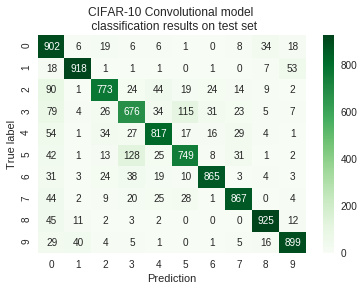

In [14]:
 # accuracy on test set

y_test_cat = np.argmax(y_test, axis=1)
preds = classifier.predict(features_test)
pred_cat = np.argmax(preds, axis=1)
print('')
print(confusion_matrix(y_test_cat, pred_cat))
print()
print('model accuracy on test set is: {}%'.format(accuracy_score(y_test_cat, pred_cat)*100))
sns.heatmap(confusion_matrix(y_test_cat, pred_cat), cmap='Greens', annot=True, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('True label')
plt.title('CIFAR-10 Convolutional model \n classification results on test set')


[[4852   11   40    2    7    0    2   13   57   16]
 [  27 4867    0    1    1    2    4    5   14   79]
 [ 177    2 4675   32   45   25   28   13    1    2]
 [ 193    2   45 4358   57  265   52   20    5    3]
 [ 121    0   54   57 4666   34   16   49    2    1]
 [ 157    1   24  341   39 4358   12   62    2    4]
 [  90    2   40   66   29   10 4751    3    6    3]
 [  98    0    6   37   30   32    1 4793    0    3]
 [  86   14    6    8    0    2    3    0 4861   20]
 [  46   66    3   11    1    2    2    5   12 4852]]

model accuracy on train set is: 94.066%


Text(0.5,1,'CIFAR-10 Convolutional model \n classification results on train set')

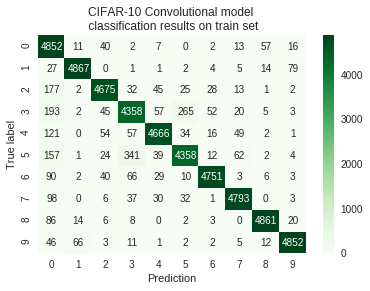

In [15]:
 # accuracy on train set

y_train_cat = np.argmax(y_train, axis=1)
preds = classifier.predict(featurs)
pred_cat = np.argmax(preds, axis=1)
print('')
print(confusion_matrix(y_train_cat, pred_cat))
print()
print('model accuracy on train set is: {}%'.format(accuracy_score(y_train_cat, pred_cat)*100))
sns.heatmap(confusion_matrix(y_train_cat, pred_cat), cmap='Greens', annot=True, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('True label')
plt.title('CIFAR-10 Convolutional model \n classification results on train set')